C:\Users\briac\AppData\Local\Temp\ipykernel_39464\37879344.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('tickers_transformed.csv', index_col='Date', parse_dates=True)


Aperçu des données :
             AMZN  AAPL   MSFT
Date                          
Amazon        NaN   NaN    NaN
1/4/2013   12.958  18.0  26.74
1/11/2013  13.397  18.0  26.83
1/18/2013  13.606  17.0  27.25
1/25/2013  14.200  15.0  27.88


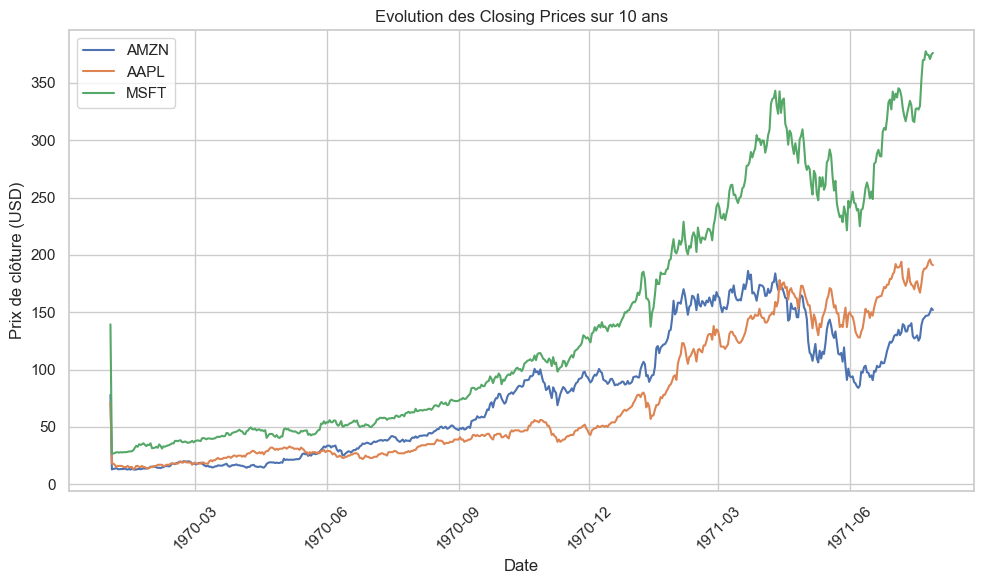

Exemple de prix call Black-Scholes pour AAPL (ATM, 3 mois): 7.85 USD
Covered Call - premiers résultats :
  entry_date  exit_date         S0   S_T     strike  call_premium  \
0     Amazon  1/25/2013  71.496516  15.0  75.071341      0.434160   
1  1/25/2013  2/22/2013  15.000000  16.0  15.750000      0.091087   
2  2/22/2013  3/22/2013  16.000000  16.0  16.800000      0.097159   
3  3/22/2013  4/19/2013  16.000000  13.0  16.800000      0.097159   
4  4/19/2013  5/17/2013  13.000000  15.0  13.650000      0.078942   

   total_profit  cumulative_profit  
0    -56.062355         -56.062355  
1      0.591087         -55.471268  
2      0.097159         -55.374109  
3     -2.902841         -58.276949  
4     -0.621058         -58.898007   

Long Straddle - premiers résultats :
  entry_date  exit_date         S0   S_T     strike  premium_call  \
0     Amazon  1/25/2013  71.496516  15.0  71.496516      1.608999   
1  1/25/2013  2/22/2013  15.000000  16.0  15.000000      0.337569   
2  2/22/2013

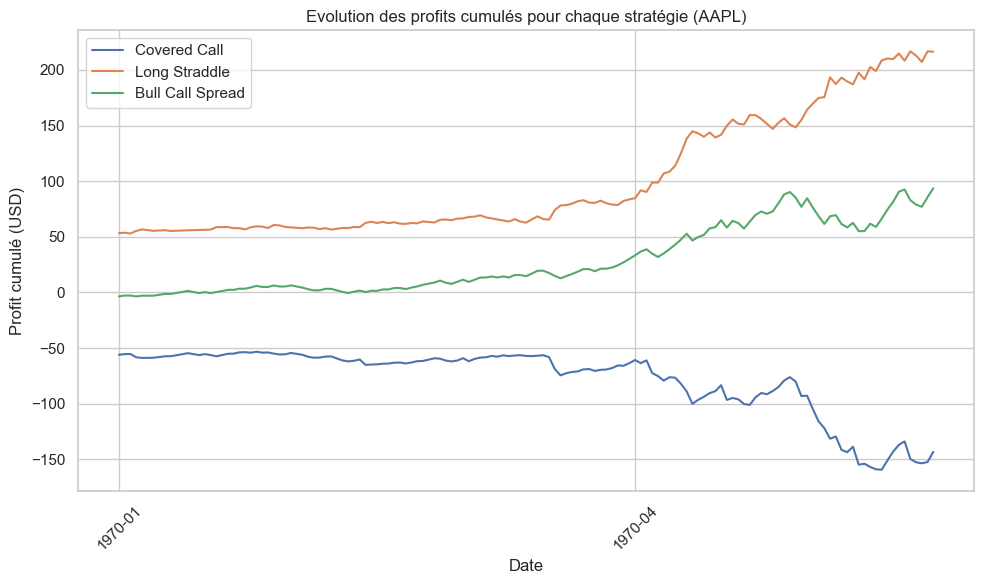

In [1]:
# =============================================================================
# 1. Importation des Bibliothèques
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from math import log, sqrt, exp, erf
import matplotlib.dates as mdates

sns.set(style="whitegrid")
plt.rc("figure", figsize=(10,6))

# =============================================================================
# 2. Lecture des Données
# =============================================================================
# On lit le fichier CSV avec les closing prices pour les trois tickers
df = pd.read_csv('tickers_transformed.csv', index_col='Date', parse_dates=True)
print("Aperçu des données :")
print(df.head())
# Remplacer les valeurs manquantes par la moyenne de la colonne
df_imputed = df.fillna(df.mean())

# =============================================================================
# 3. Analyse Exploratoire
# =============================================================================
plt.figure(figsize=(10,6))
for ticker in df_imputed.columns:
    plt.plot(df_imputed.index, df_imputed[ticker], label=ticker)
plt.title("Evolution des Closing Prices sur 10 ans")
plt.xlabel("Date")
plt.ylabel("Prix de clôture (USD)")
plt.legend()

# Configuration de l'affichage de l'axe des dates
plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.tight_layout()
plt.show()

# Calcul des rendements logarithmiques
returns = np.log(df_imputed / df_imputed.shift(1))
returns = returns.dropna()

# =============================================================================
# 4. Modèle de Valorisation des Options : Black-Scholes (avec paramètres fixes)
# =============================================================================
def norm_cdf(x):
    """Fonction de répartition de la loi normale standard"""
    return 0.5 * (1 + erf(x / sqrt(2)))

def black_scholes_price(S, K, T, r, sigma, option_type="call"):
    """
    Calcule le prix théorique Black-Scholes d'une option européenne.
    
    S      : Prix spot du sous-jacent
    K      : Strike
    T      : Temps jusqu'à l'échéance (en années)
    r      : Taux sans risque
    sigma  : Volatilité annualisée (fixe ici, par ex. 0.2 pour 20%)
    option_type : "call" ou "put"
    """
    if T <= 0:
        return max(0.0, S-K) if option_type == "call" else max(0.0, K-S)
    
    d1 = (log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    if option_type == "call":
        price = S * norm_cdf(d1) - K * exp(-r * T) * norm_cdf(d2)
    elif option_type == "put":
        price = K * exp(-r * T) * norm_cdf(-d2) - S * norm_cdf(-d1)
    else:
        raise ValueError("option_type must be either 'call' or 'put'")
    return price

# Exemple d'utilisation avec AAPL (dernier prix)
ticker_example = 'AAPL'
S_example = df_imputed[ticker_example].iloc[-1]
prix_call_example = black_scholes_price(S_example, K=S_example, T=0.25, r=0.01, sigma=0.2, option_type="call")
print(f"Exemple de prix call Black-Scholes pour {ticker_example} (ATM, 3 mois): {prix_call_example:.2f} USD")

# =============================================================================
# 5. Fonctions de Backtesting avec Paramètres Fixes
# =============================================================================

FIXED_SIGMA = 0.2  # Volatilité fixée à 20%
FIXED_R = 0.01     # Taux sans risque à 1%

def backtest_covered_call(price_series, maturity_weeks=4, strike_margin=1.05, r=FIXED_R, sigma=FIXED_SIGMA):
    results = []
    prices = price_series.copy()
    n = len(prices)
    step = maturity_weeks
    for i in range(0, n - step, step):
        S0 = prices.iloc[i]
        K = S0 * strike_margin
        T = maturity_weeks / 52.0
        call_price = black_scholes_price(S0, K, T, r, sigma, option_type="call")
        S_T = prices.iloc[i + step]
        call_payoff = -max(0, S_T - K)
        stock_profit = (K - S0) if S_T > K else (S_T - S0)
        total_profit = stock_profit + call_price + call_payoff
        results.append({
            "entry_date": prices.index[i],
            "exit_date": prices.index[i+step],
            "S0": S0,
            "S_T": S_T,
            "strike": K,
            "call_premium": call_price,
            "total_profit": total_profit
        })
    df_results = pd.DataFrame(results)
    df_results["cumulative_profit"] = df_results["total_profit"].cumsum()
    return df_results

def backtest_straddle(price_series, maturity_weeks=4, r=FIXED_R, sigma=FIXED_SIGMA):
    results = []
    prices = price_series.copy()
    n = len(prices)
    step = maturity_weeks
    for i in range(0, n - step, step):
        S0 = prices.iloc[i]
        K = S0
        T = maturity_weeks / 52.0
        call_price = black_scholes_price(S0, K, T, r, sigma, option_type="call")
        put_price  = black_scholes_price(S0, K, T, r, sigma, option_type="put")
        premium_total = call_price + put_price
        S_T = prices.iloc[i + step]
        call_payoff = max(0, S_T - K)
        put_payoff  = max(0, K - S_T)
        total_profit = (call_payoff + put_payoff) - premium_total
        results.append({
            "entry_date": prices.index[i],
            "exit_date": prices.index[i+step],
            "S0": S0,
            "S_T": S_T,
            "strike": K,
            "premium_call": call_price,
            "premium_put": put_price,
            "total_profit": total_profit
        })
    df_results = pd.DataFrame(results)
    df_results["cumulative_profit"] = df_results["total_profit"].cumsum()
    return df_results

def backtest_bull_call_spread(price_series, maturity_weeks=4,
                              lower_strike_margin=0.95, upper_strike_margin=1.05,
                              r=FIXED_R, sigma=FIXED_SIGMA):
    results = []
    prices = price_series.copy()
    n = len(prices)
    step = maturity_weeks
    for i in range(0, n - step, step):
        S0 = prices.iloc[i]
        K1 = S0 * lower_strike_margin
        K2 = S0 * upper_strike_margin
        T = maturity_weeks / 52.0
        call_buy_price = black_scholes_price(S0, K1, T, r, sigma, option_type="call")
        call_sell_price = black_scholes_price(S0, K2, T, r, sigma, option_type="call")
        net_premium = call_buy_price - call_sell_price
        S_T = prices.iloc[i + step]
        call_buy_payoff = max(0, S_T - K1)
        call_sell_payoff = -max(0, S_T - K2)
        total_profit = (call_buy_payoff + call_sell_payoff) - net_premium
        results.append({
            "entry_date": prices.index[i],
            "exit_date": prices.index[i+step],
            "S0": S0,
            "S_T": S_T,
            "strike_buy": K1,
            "strike_sell": K2,
            "net_premium": net_premium,
            "total_profit": total_profit
        })
    df_results = pd.DataFrame(results)
    df_results["cumulative_profit"] = df_results["total_profit"].cumsum()
    return df_results

# =============================================================================
# 6. Exécution du Backtesting sur un Ticker (exemple AAPL)
# =============================================================================
price_series = df_imputed['AAPL']
maturity = 4  # options mensuelles (4 semaines)

cc_results      = backtest_covered_call(price_series, maturity_weeks=maturity)
straddle_results= backtest_straddle(price_series, maturity_weeks=maturity)
spread_results  = backtest_bull_call_spread(price_series, maturity_weeks=maturity)

print("Covered Call - premiers résultats :")
print(cc_results.head(), "\n")
print("Long Straddle - premiers résultats :")
print(straddle_results.head(), "\n")
print("Bull Call Spread - premiers résultats :")
print(spread_results.head())

# =============================================================================
# 7. Visualisation des Profits Cumulés avec Affichage Lisible des Dates
# =============================================================================
plt.figure(figsize=(10,6))
plt.plot(cc_results["exit_date"], cc_results["cumulative_profit"], label="Covered Call")
plt.plot(straddle_results["exit_date"], straddle_results["cumulative_profit"], label="Long Straddle")
plt.plot(spread_results["exit_date"], spread_results["cumulative_profit"], label="Bull Call Spread")
plt.title("Evolution des profits cumulés pour chaque stratégie (AAPL)")
plt.xlabel("Date")
plt.ylabel("Profit cumulé (USD)")
plt.legend()

plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.tight_layout()
plt.show()


### =============================================================================
### Fin du Code ###


#cccc